In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from pprint import pprint
from datetime import datetime
import os
import csv

In [3]:
yr = 2021
fire_gdf = gpd.read_file(f'../outputs/geojson/clean/ca_fire_{yr}.geojson').set_crs(4326)
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,AGENCY,FIRE_NAME,geometry
0,2021-03-01,2021-03-01,18,Escaped Prescribed Burn,257.83230,CDF,CALVERT,"MULTIPOLYGON (((-118.22247 36.99579, -118.2224..."
1,2021-04-05,2021-04-05,5,Debris,21.86377,LRA,MEISS,"POLYGON ((-122.08409 41.83950, -122.08485 41.8..."
2,2021-03-27,2021-03-29,18,Escaped Prescribed Burn,873.39170,LRA,REFUGE,"POLYGON ((-121.62419 41.93584, -121.63292 41.9..."
3,2021-01-19,2021-01-22,9,Miscellaneous,20.30736,CDF,BONNY COMPLEX,"MULTIPOLYGON (((-122.13407 37.08391, -122.1342..."
4,2021-01-19,2021-01-22,11,Powerline,33.25922,CDF,FREEDOM,"MULTIPOLYGON (((-121.83895 36.97447, -121.8389..."


In [4]:
columns_to_drop = ['FIRE_NAME', 'AGENCY', 'geometry']
fire_gdf.drop(columns=columns_to_drop, inplace=True)

In [5]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES
0,2021-03-01,2021-03-01,18,Escaped Prescribed Burn,257.83230
1,2021-04-05,2021-04-05,5,Debris,21.86377
2,2021-03-27,2021-03-29,18,Escaped Prescribed Burn,873.39170
3,2021-01-19,2021-01-22,9,Miscellaneous,20.30736
4,2021-01-19,2021-01-22,11,Powerline,33.25922


In [6]:
fire_gdf['CONT_DATE'] = pd.to_datetime(fire_gdf['CONT_DATE'])
fire_gdf['ALARM_DATE'] = pd.to_datetime(fire_gdf['ALARM_DATE'])
fire_gdf['Duration'] = fire_gdf['CONT_DATE'] - fire_gdf['ALARM_DATE']

In [7]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,2021-03-01,2021-03-01,18,Escaped Prescribed Burn,257.83230,0 days
1,2021-04-05,2021-04-05,5,Debris,21.86377,0 days
2,2021-03-27,2021-03-29,18,Escaped Prescribed Burn,873.39170,2 days
3,2021-01-19,2021-01-22,9,Miscellaneous,20.30736,3 days
4,2021-01-19,2021-01-22,11,Powerline,33.25922,3 days


In [8]:
average_duration = []
average_acres = []
cause_df = fire_gdf.sort_values(by='CAUSE_ID').reset_index()
def average_calc(i, df):
    test_df = df.loc[df['CAUSE_ID'] == i]
    days = []
    for d in test_df['Duration']:
        days.append(d.days)
    if len(days) != 0:
        average_d = round(sum(days)/len(days), 2)
    else:
        average_d = 0
    average_a = round(test_df['GIS_ACRES'].mean(),2)
    return average_d, average_a

for i in cause_df['CAUSE_ID'].unique():
    d, a = average_calc(i, cause_df)
    average_duration.append(d)
    average_acres.append(a)
cause_list = cause_df['CAUSE'].unique()
cause_df.head()

,index,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,282,2021-07-05,2021-07-21,1,Lightning,882.02480,16 days
1,310,2021-10-11,2021-12-01,1,Lightning,16953.24000,51 days
2,326,2021-06-17,2021-06-27,1,Lightning,47.47640,10 days
3,327,2021-06-20,2021-06-20,1,Lightning,25.38194,0 days
4,201,2021-06-18,2021-06-21,1,Lightning,423.56090,3 days


In [9]:
counts = cause_df.groupby('CAUSE_ID').size()
source_df = pd.DataFrame({'Causes' : cause_list, 
                          'Average Duration (days)' : average_duration, 
                          'Average GIS Acres' : average_acres,
                          'Number of Occurences (in the Year)' : counts})
source_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,37.57,22560.90,49
2,Equipment Use,19.83,447.06,47
3,Smoking,3.50,62.20,2
4,Campfire,3.57,157.18,7
5,Debris,1.55,63.46,29
6,Railroad,0.00,18.60,1
7,Arson,1.45,496.17,20
8,Playing with fire,0.50,16.05,2
9,Miscellaneous,7.58,178.33,45


In [19]:
source_clean_df = source_df.drop(index = [9,14], inplace = False)
source_clean_df.to_csv("outputs/fire_source_2021.csv",
                  encoding="utf-8", index=False, header=True)
source_clean_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,37.57,22560.90,49
2,Equipment Use,19.83,447.06,47
3,Smoking,3.50,62.20,2
4,Campfire,3.57,157.18,7
5,Debris,1.55,63.46,29
6,Railroad,0.00,18.60,1
7,Arson,1.45,496.17,20
8,Playing with fire,0.50,16.05,2
10,Vehicle,0.44,42.48,32


In [11]:
man_duration = 0
man_GIS_acres = 0
man_oc = 0
nat_duration = 0
nat_GIS_acres = 0
nat_oc = 0
for index, row in source_clean_df.iterrows():
    if row['Causes'] == 'Lightning':
        nat_duration += row['Average Duration (days)']
        nat_GIS_acres += row['Average GIS Acres']
        nat_oc += row['Number of Occurences (in the Year)']
    else:
        man_duration += row['Average Duration (days)'] 
        man_GIS_acres += row['Average GIS Acres']
        man_oc += row['Number of Occurences (in the Year)']

man_vs_nature_df = pd.DataFrame({'Causes':['Man-Made', 'Natural'], 
                                 'Average Duration (days)': [man_duration, nat_duration], 
                                 'Average GIS Acres': [man_GIS_acres, nat_GIS_acres],
                                 'Number of Occurences (in the Year)':[man_oc, nat_oc]
                                })
man_vs_nature_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Man-Made,41.16,61777.35,165
1,Natural,37.57,22560.90,49


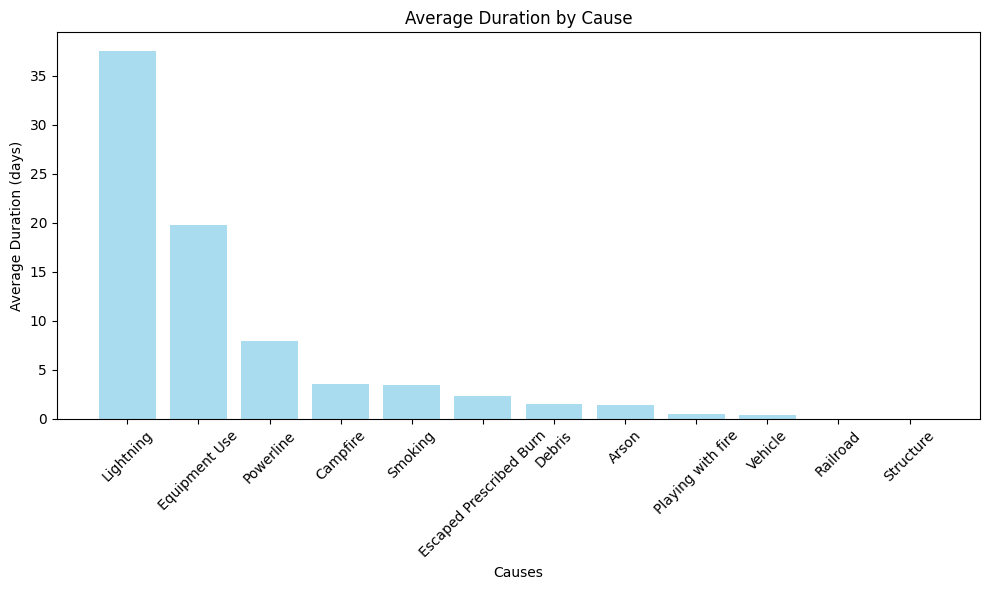

In [12]:
source_clean_df = source_clean_df.sort_values(by='Average Duration (days)', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

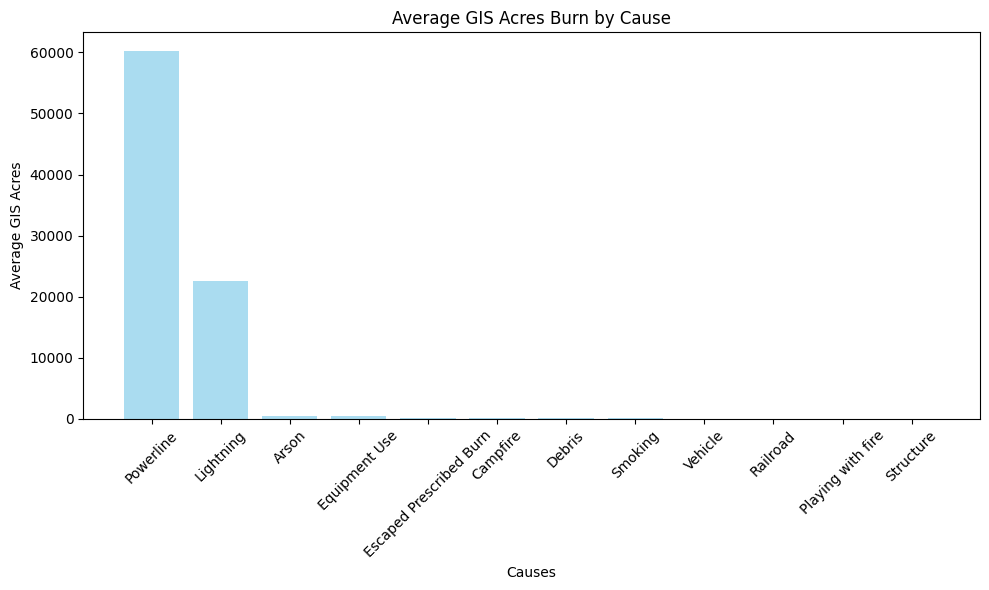

In [13]:
source_clean_df = source_clean_df.sort_values(by='Average GIS Acres', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

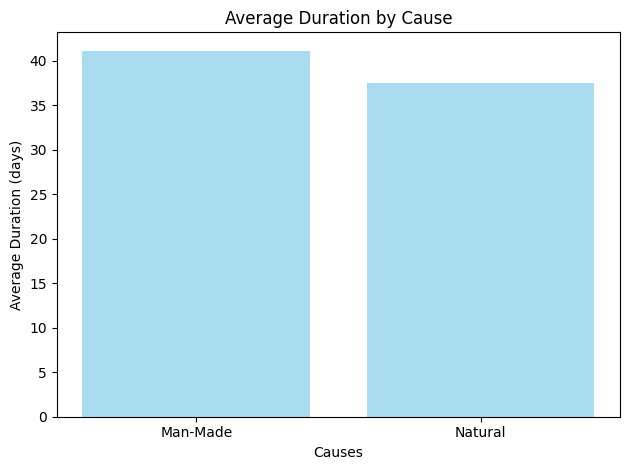

In [14]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.tight_layout()
plt.show()

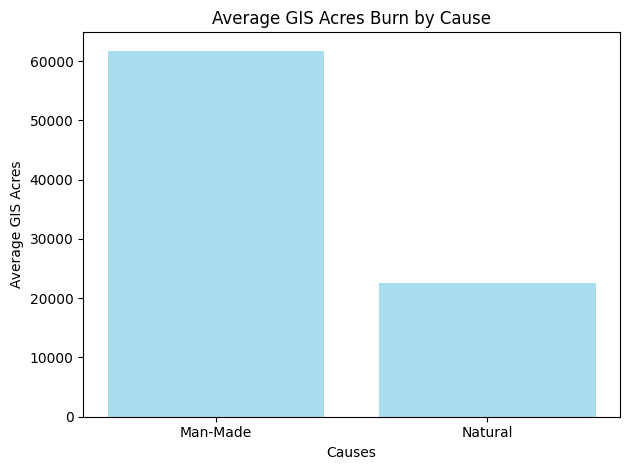

In [15]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.tight_layout()
plt.show()

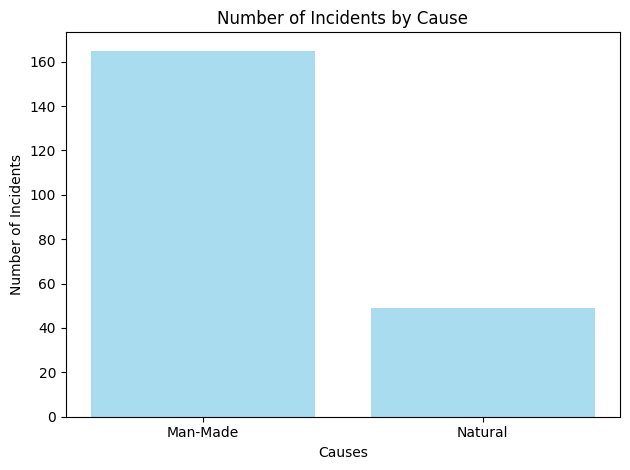

In [16]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Number of Occurences (in the Year)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Cause')

plt.tight_layout()
plt.show()